In [1]:
import random
from dataclasses import dataclass, field
from typing import Optional

import clingo
import networkx as nx
from clingox.program import Program, ProgramObserver
from clingraph import Factbase, compute_graphs

In [2]:
inst_toy = """

node(1..14).

edge(( 1, 2)).
edge(( 1,13)).
edge(( 2, 3)).
edge(( 2,14)).
edge(( 3, 4)).
edge(( 3, 5)).
edge(( 4, 5)).
edge(( 5, 6)).
edge(( 5, 7)).
edge(( 6, 7)).
edge(( 6,14)).
edge(( 7, 8)).
edge(( 8, 9)).
edge(( 8,12)).
edge(( 9,10)).
edge(( 9,11)).
edge(( 9,12)).
edge((10,11)).
edge((12,13)).
edge((12,14)).
edge((13,14)).
edge((U,V)) :- edge((V,U)).

edge_weight(( 1, 2),17). edge_weight(( 2, 1),16).
edge_weight(( 1,13),35). edge_weight((13, 1),15).
edge_weight(( 2, 3),11). edge_weight(( 3, 2),8).
edge_weight(( 2,14),18). edge_weight((14, 2),3).
edge_weight(( 3, 4),1). edge_weight(( 4, 3),3).
edge_weight(( 3, 5),4). edge_weight(( 5, 3),3).
edge_weight(( 4, 5),7). edge_weight(( 5, 4),5).
edge_weight(( 5, 6),2). edge_weight(( 6, 5),1).
edge_weight(( 5, 7),3). edge_weight(( 7, 5),2).
edge_weight(( 6, 7),2). edge_weight(( 7, 6),2).
edge_weight(( 6,14),14). edge_weight((14, 6),11).
edge_weight(( 7, 8),12). edge_weight(( 8, 7),8).
edge_weight(( 8, 9),6). edge_weight(( 9, 8),2).
edge_weight(( 8,12),18). edge_weight((12, 8),20).
edge_weight(( 9,10),6). edge_weight((10, 9),7).
edge_weight(( 9,11),26). edge_weight((11, 9),30).
edge_weight(( 9,12),8). edge_weight((12, 9),14).
edge_weight((10,11),11). edge_weight((11,10),5).
edge_weight((12,13),9). edge_weight((13,12),15).
edge_weight((12,14),6). edge_weight((14,12),9).
edge_weight((13,14),7). edge_weight((14,13),5).

"""

In [3]:
inst2 = """

node(1).
node(2).
node(3).
node(4).

edge((1,2)).
edge((1,3)).
edge((1,4)).
edge((2,1)).
edge((2,3)).
edge((3,1)).
edge((3,2)).
edge((3,4)).
edge((4,1)).
edge((4,3)).

edge_weight((1,2), 10).
edge_weight((2,3), 10).
edge_weight((3,1), 10).
edge_weight((3,4), 10).
edge_weight((4,1), 10).
edge_weight((1,4), 100).
edge_weight((2,1), 100).
edge_weight((3,2), 100).
edge_weight((1,3), 100).
edge_weight((4,3), 100).

"""

In [4]:
viz = """

attr(edge, E, label, W) :- edge(E), edge_weight(E, W).
attr(edge, E, dir, forward) :- edge(E).

%attr(edge, E, color, gray) :- edge(E), #count { T : walk(E, T) } = 0.
%attr(edge, E, color, red) :- edge(E), #count { T : walk(E, T) } = W, W >= 1.
%attr(edge, E, width, W) :- edge(E), #count { T : walk(E, T) } = W, W >= 1.
%attr(edge, E, style, dashed) :- edge(E), not walk(E, _).

attr(graph, default, model, "circuit").

"""

In [5]:
reasoning = """

#program derived.

pos(V) :- walk((_,V)).

cost(C + W) :- C = @prev_cost(), walk(E), W = @weight(E).
tour :- pos(1).
complete :- walk(E), @visited_all(E) = true.

#program choice.

1 { walk(E) : E = @edges(V), V = @pos() } 1.

#program goal.

goal :- tour, complete.

"""

In [6]:
@dataclass
class GraphContext:
    graph: nx.DiGraph
    p_cost: int = 0
    visited: frozenset = field(default_factory=frozenset)
    position: int = 1
    __all_edges:Optional[frozenset] = None

    @staticmethod
    def get_edge(edge: clingo.Symbol, graph: Optional[nx.Graph] = None):
        outgoing_node = edge.arguments[0].number
        incoming_node = edge.arguments[1].number
        weight = None
        if graph is not None:
            weight = graph[outgoing_node][incoming_node]['weight']
        return outgoing_node, incoming_node, weight

    def prev_cost(self):
        return clingo.Number(self.p_cost)

    def weight(self, edge: clingo.Symbol):
        _, _, weight = GraphContext.get_edge(edge, self.graph)
        return clingo.Number(weight)

    def visited_all(self, edge: clingo.Symbol):
        if len(self.visited) + 1 < len(self.graph.edges) // 2:
            return clingo.Function("false")
        outgoing_node, incoming_node, _ = GraphContext.get_edge(edge)
        visited_edges = set(self.visited)
        visited_edges.add(tuple(sorted((outgoing_node, incoming_node))))
        #print(visited_edges, all_edges)
        if self.__all_edges is None:
            self.__all_edges = frozenset(map(tuple, map(sorted, self.graph.edges)))
        if visited_edges == self.__all_edges:
            return clingo.Function("true")
        return clingo.Function("false")

    def edges(self, vertex: clingo.Symbol):
        v = vertex.number
        ns = self.graph.successors(v)
        return [clingo.Tuple_((vertex, clingo.Number(n))) for n in ns]

    def pos(self):
        return clingo.Number(self.position)

In [7]:
@dataclass
class SearchNode:
    position: int = 1
    visited: frozenset = field(default_factory=frozenset)
    p_cost: int = 0
    goal: bool = False
    actions: tuple = ()

    def create_context(self, graph):
        return GraphContext(graph=graph, visited=self.visited, p_cost=self.p_cost, position=self.position)

    def expand(self, graph):
        ctl = clingo.Control()
        ctl.configuration.solve.models = 0

        prg = Program()
        obs = ProgramObserver(prg)
        ctl.register_observer(obs)

        ctl.add("base", (), reasoning)
        ctx = self.create_context(graph)
        ctl.ground([("base", []), ("choice", []), ("derived", []), ("goal", [])], context=ctx)

        #print("Facts:", len(prg.facts), "Rules:", len(prg.rules))
        #print("-" * 20)
        #print(prg)
        #print("-" * 20)

        children = []
        with ctl.solve(yield_=True) as solve_handle:
            for model in solve_handle:
                position = None
                visited = set(self.visited)
                p_cost = None
                goal = False
                actions = self.actions
                atoms = model.symbols(atoms=True)
                #print('{', ' '.join(map(str, sorted(atoms))), '}')
                for atom in atoms:
                    if atom.match('pos', 1):
                        position = atom.arguments[0].number
                    elif atom.match('walk', 1):
                        edge = atom.arguments[0]
                        outgoing_node, incoming_node, _ = GraphContext.get_edge(edge)
                        visited.add(tuple(sorted((outgoing_node, incoming_node))))
                        actions = (*actions, (outgoing_node, incoming_node))
                    elif atom.match('cost', 1):
                        p_cost = atom.arguments[0].number
                    elif atom.match('goal', 0):
                        goal = True
                child = SearchNode(position=position, visited=frozenset(visited), p_cost=p_cost, goal=goal,
                                   actions=actions)
                children.append(child)

        return children

    def __hash__(self):
        return hash(('SearchNode', self.position, self.visited, self.p_cost))

In [8]:
ctl = clingo.Control()
ctl.configuration.solve.models = 1
ctl.add("base", (), inst_toy)
ctl.add("base", (), viz)
ctl.ground([("base", ())])

graph = nx.DiGraph()
with ctl.solve(yield_=True) as solve_handle:
    solve_handle.get()
    model = solve_handle.model()
    atoms = model.symbols(atoms=True)
    print("Answer: ", ' '.join(map(str, sorted(atoms))))
    fb = Factbase()
    fb.add_model(model)
    for atom in atoms:
        if atom.match('node', 1):
            graph.add_node(atom.arguments[0].number)
        elif atom.match('edge_weight', 2):
            edge, weight = atom.arguments
            outgoing_node, incoming_node, _ = GraphContext.get_edge(edge)
            weight = weight.number
            graph.add_edge(outgoing_node, incoming_node, weight=weight)

print(fb)

Answer:  edge((1,2)) edge((1,13)) edge((2,1)) edge((2,3)) edge((2,14)) edge((3,2)) edge((3,4)) edge((3,5)) edge((4,3)) edge((4,5)) edge((5,3)) edge((5,4)) edge((5,6)) edge((5,7)) edge((6,5)) edge((6,7)) edge((6,14)) edge((7,5)) edge((7,6)) edge((7,8)) edge((8,7)) edge((8,9)) edge((8,12)) edge((9,8)) edge((9,10)) edge((9,11)) edge((9,12)) edge((10,9)) edge((10,11)) edge((11,9)) edge((11,10)) edge((12,8)) edge((12,9)) edge((12,13)) edge((12,14)) edge((13,1)) edge((13,12)) edge((13,14)) edge((14,2)) edge((14,6)) edge((14,12)) edge((14,13)) node(1) node(2) node(3) node(4) node(5) node(6) node(7) node(8) node(9) node(10) node(11) node(12) node(13) node(14) edge_weight((1,2),17) edge_weight((1,13),35) edge_weight((2,1),16) edge_weight((2,3),11) edge_weight((2,14),18) edge_weight((3,2),8) edge_weight((3,4),1) edge_weight((3,5),4) edge_weight((4,3),3) edge_weight((4,5),7) edge_weight((5,3),3) edge_weight((5,4),5) edge_weight((5,6),2) edge_weight((5,7),3) edge_weight((6,5),1) edge_weight((6,7),

In [9]:
graphs = compute_graphs(fb)
graphs

{'default': <graphviz.graphs.Graph at 0x7f33431379a0>}

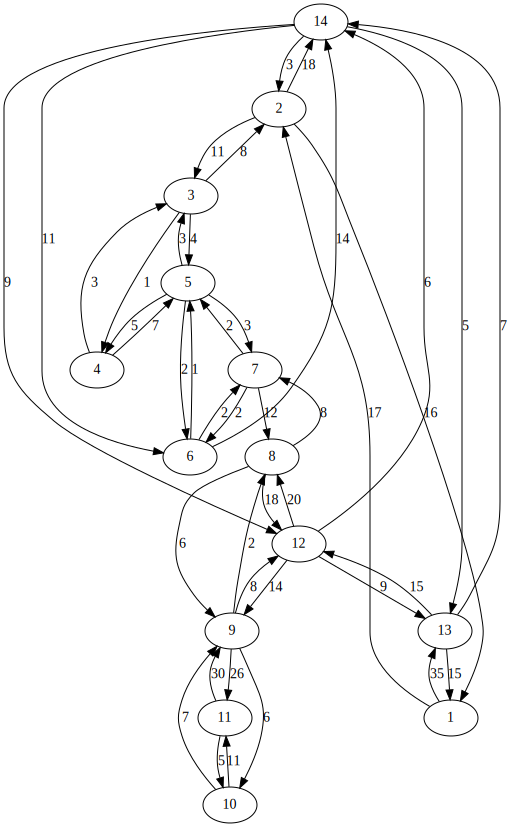

In [10]:
graphs['default']

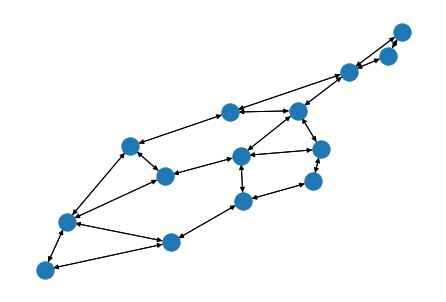

In [11]:
nx.draw(graph)

In [12]:
graph.edges(data=True)

OutEdgeDataView([(1, 2, {'weight': 17}), (1, 13, {'weight': 35}), (2, 1, {'weight': 16}), (2, 3, {'weight': 11}), (2, 14, {'weight': 18}), (3, 2, {'weight': 8}), (3, 4, {'weight': 1}), (3, 5, {'weight': 4}), (4, 3, {'weight': 3}), (4, 5, {'weight': 7}), (5, 3, {'weight': 3}), (5, 4, {'weight': 5}), (5, 6, {'weight': 2}), (5, 7, {'weight': 3}), (6, 5, {'weight': 1}), (6, 7, {'weight': 2}), (6, 14, {'weight': 14}), (7, 5, {'weight': 2}), (7, 6, {'weight': 2}), (7, 8, {'weight': 12}), (8, 7, {'weight': 8}), (8, 9, {'weight': 6}), (8, 12, {'weight': 18}), (9, 8, {'weight': 2}), (9, 10, {'weight': 6}), (9, 11, {'weight': 26}), (9, 12, {'weight': 8}), (10, 9, {'weight': 7}), (10, 11, {'weight': 11}), (11, 9, {'weight': 30}), (11, 10, {'weight': 5}), (12, 8, {'weight': 20}), (12, 9, {'weight': 14}), (12, 13, {'weight': 9}), (12, 14, {'weight': 6}), (13, 1, {'weight': 15}), (13, 12, {'weight': 15}), (13, 14, {'weight': 7}), (14, 2, {'weight': 3}), (14, 6, {'weight': 11}), (14, 12, {'weight': 9

In [13]:
fringe = []
root = SearchNode()
closed = set()
fringe.append(root)
best_solution = (None, 1 + sum(edge[-1]['weight'] for edge in graph.edges(data=True)))
explored = 0
print("Starting search:")
print("Fringe:", fringe)
print("Best solution:", best_solution)

Starting search:
Fringe: [SearchNode(position=1, visited=frozenset(), p_cost=0, goal=False, actions=())]
Best solution: (None, 408)


In [14]:
def run(fringe, bs):
    best_solution = bs
    explored = 0
    while fringe:
        explored += 1
        if explored % 500_000 == 1:
            print("Sort good ({},{})".format(len(fringe), explored))
            fringe.sort(key=lambda c: c.p_cost, reverse=True)
            fringe.sort(key=lambda c: len(c.visited))
            fringe.sort(key=lambda c: c.goal)
        elif explored % 500_000 == 125_000:
            print("Sort early ({},{})".format(len(fringe), explored))
            fringe.sort(key=lambda c: len(c.actions), reverse=True)
            fringe.sort(key=lambda c: c.goal)
        elif explored % 500_000 == 250_000:
            print("Shuffle ({},{})".format(len(fringe), explored))
            random.shuffle(fringe)
        elif explored % 500_000 == 375_000:
            print("Sort bad ({},{})".format(len(fringe), explored))
            fringe.sort(key=lambda c: len(c.actions))
            fringe.sort(key=lambda c: c.p_cost)

        node = fringe.pop()
        #print(node)
        if node.p_cost > best_solution[1]:
            #print("Node removed.", "Current best:", best_solution[1], "Fringe size:", len(fringe))
            continue

        if node.goal:
            best_solution = node.actions, node.p_cost
            print("Goal reached, new best:", node.p_cost)
            continue

        if len(node.actions) > 30:
            continue

        children = node.expand(graph)
        children.sort(key=lambda c: c.goal)

        fringe.extend(children)
    return fringe, best_solution, explored

In [15]:
%time run(fringe, best_solution)


Sort good (1,1)
Sort early (44,125000)
Shuffle (83,250000)
Sort bad (102,375000)
Sort good (92,500001)
Sort early (84,625000)
Shuffle (124,750000)
Sort bad (141,875000)
Sort good (126,1000001)
Sort early (129,1125000)
Shuffle (168,1250000)
Sort bad (207,1375000)
Sort good (173,1500001)
Sort early (188,1625000)
Shuffle (223,1750000)
Sort bad (245,1875000)
Sort good (236,2000001)
Sort early (232,2125000)
Shuffle (278,2250000)
Sort bad (308,2375000)
Sort good (297,2500001)
Sort early (312,2625000)
Shuffle (345,2750000)
Sort bad (364,2875000)
Sort good (347,3000001)
Sort early (361,3125000)
Shuffle (398,3250000)
Sort bad (413,3375000)
Sort good (392,3500001)
Sort early (418,3625000)
Shuffle (457,3750000)
Sort bad (480,3875000)
Sort good (465,4000001)
Sort early (476,4125000)
Shuffle (518,4250000)
Sort bad (529,4375000)
Sort good (536,4500001)
Sort early (547,4625000)
Shuffle (586,4750000)
Sort bad (614,4875000)
Sort good (603,5000001)
Sort early (604,5125000)
Shuffle (641,5250000)
Sort bad

KeyboardInterrupt: 